# **Q6. Business Case: Apollo Hospitals - Hypothesis Testing**

## **Problem Statement:**
### 1. Clean, sanitize and manipulate data to identify which variables are significant in predicting the reason for hospitalization for different regions.
### 2. Analyze how well some variables like viral load, smoking, Severity Level describe the hospitalization charges.

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
import pylab
import missingno as msno

In [21]:
pd.set_option('display.max_columns', None)
minmaxscaler = MinMaxScaler()
standardscaler = StandardScaler()
sns.set_theme(style="darkgrid")
continuous_types = ['float64', 'datetime64[ns]']
discrete_types = ['int64']
numeric_types = ['int64', 'float64']
categorical_types = ['category', 'bool']
get_columns_by_types = lambda df, types: [df.columns[index] for index in range(len(df.columns)) if df.dtypes[index].name in types]
right_skew_transformations = [['natural log', lambda x: np.log(x)],
                  ['log base 10', lambda x: np.log10(x)],
                 ['log base 2', lambda x: np.log2(x)],
                 ['square root', lambda x: (x)**(1/2)],
                 ['cube root', lambda x: (x)**(1/3)]]
left_skew_transformations = [['exponential', lambda x: np.exp(x)],
                 ['square', lambda x: (x)**(2)],
                 ['cube', lambda x: (x)**(3)]]

In [3]:
def convert_to_best_type(df):
    for column in df.columns:
        try:
            if np.any(df[column].apply(lambda x: '.' in str(x))):
                df[column] = df[column].astype('float64')
            else:
                if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                    df[column] = df[column].astype(bool)
                elif len(df[column].unique())<10:
                    df[column] = pd.Categorical(df[column])
                else:
                    df[column] = df[column].astype('int64')
        except:
            if np.any(df[column].apply(lambda x: str(x).lower()=='true' or str(x).lower()=='false')):
                df[column] = df[column].astype(bool)
            elif np.any(df[column].apply(lambda x: ':' in str(x))):
                df[column] = pd.to_datetime(df[column])
            elif len(df[column].unique())<10:
                df[column] = pd.Categorical(df[column])
            else:
                df[column] = df[column].astype('string')
    return df

In [4]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    outlier_fraction = (len(df_in)-len(df_out))/len(df_in)
    if outlier_fraction > 0.0:
        fig, axes = plt.subplots(1, 1, sharex=True, figsize=(18,6))
        sns.boxplot(data=df_in, y=col_name)
        if outlier_fraction <= 0.10:
            fig.suptitle(f"Outliers constitute {round(outlier_fraction*100, 2)}% of data for column '{col_name}'. Hence removing outliers.", fontsize=20, color="green")
            plt.show()
            return df_out
        else:
            fig.suptitle(f"Outliers constitute significant amount of data ({round(outlier_fraction*100, 2)}%) for column '{col_name}'. Hence not removing outliers..", fontsize=20, color="green")
            plt.show()
            return df_in
    else:
        return df_in

***
***
## **1. Analyzing Basic Metrics.**

In [5]:
filename = 'scaler_apollo_hospitals.csv'
df = pd.read_csv(filename)
df = convert_to_best_type(df)

In [6]:
df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


In [7]:
df.drop(df.columns[0], axis=1, inplace=True)
df.head()

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667


In [8]:
print("Shape:", df.shape, "\n")

Shape: (1338, 7) 



In [9]:
df.dtypes

age                           int64
sex                        category
smoker                     category
region                     category
viral load                  float64
severity level             category
hospitalization charges       int64
dtype: object

***
***
## **2. Missing Values.**

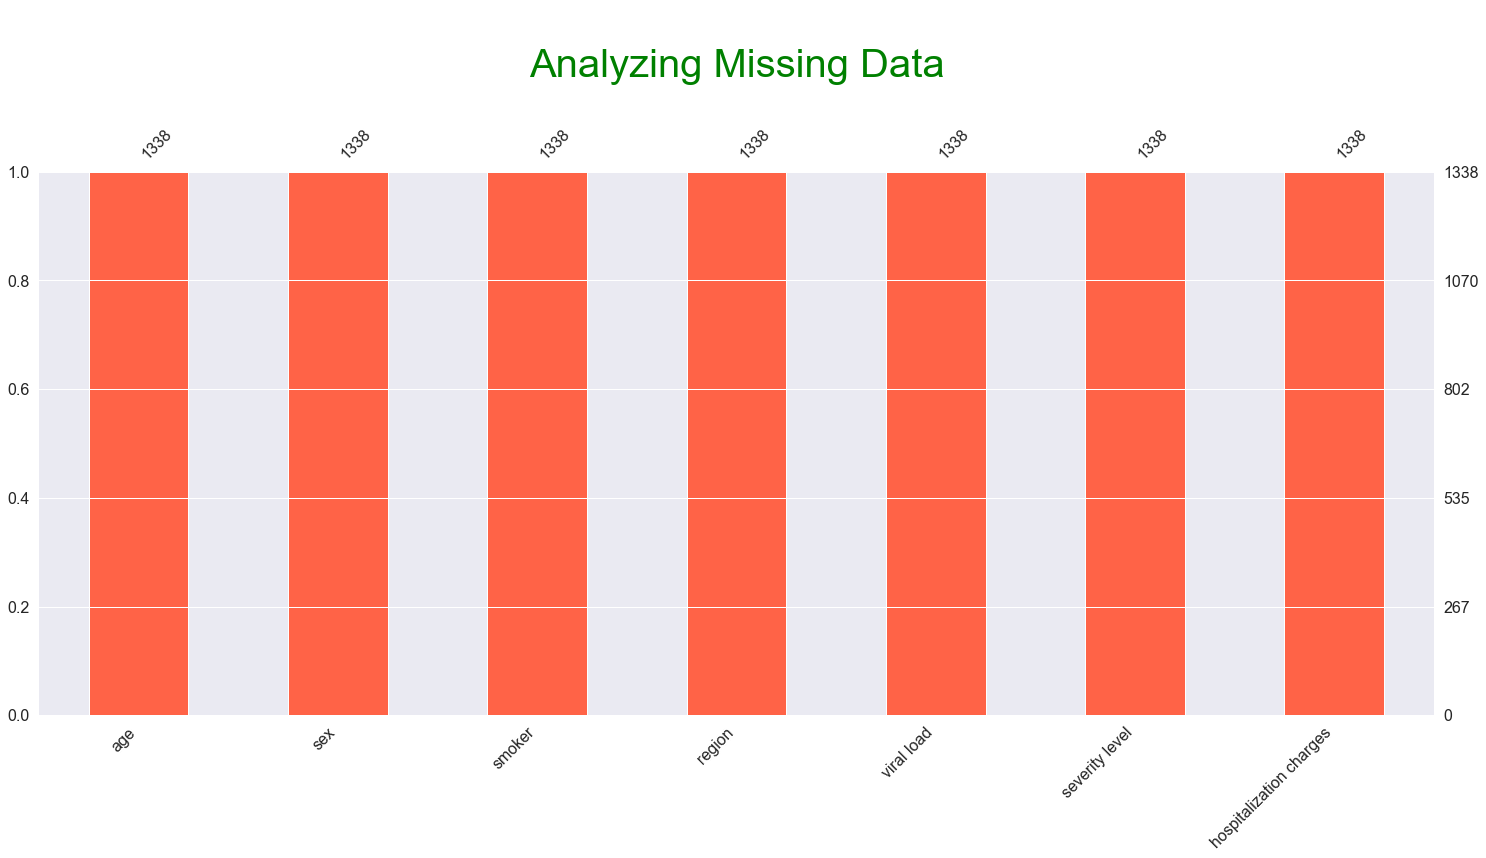

In [10]:
msno.bar(df, color='tomato')
plt.title("\nAnalyzing Missing Data\n", fontsize=40, color="green")
plt.show()

***
***
## **3. Outlier Detection & Treatment.**

In [11]:
df.describe()

,age,viral load,hospitalization charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


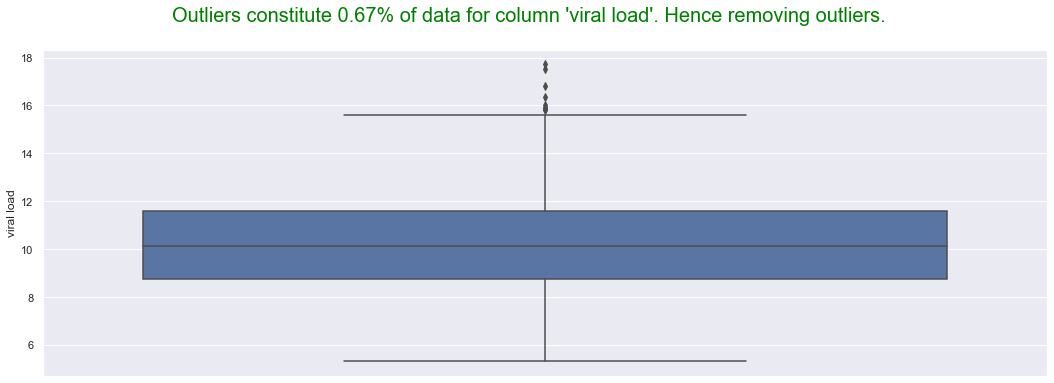

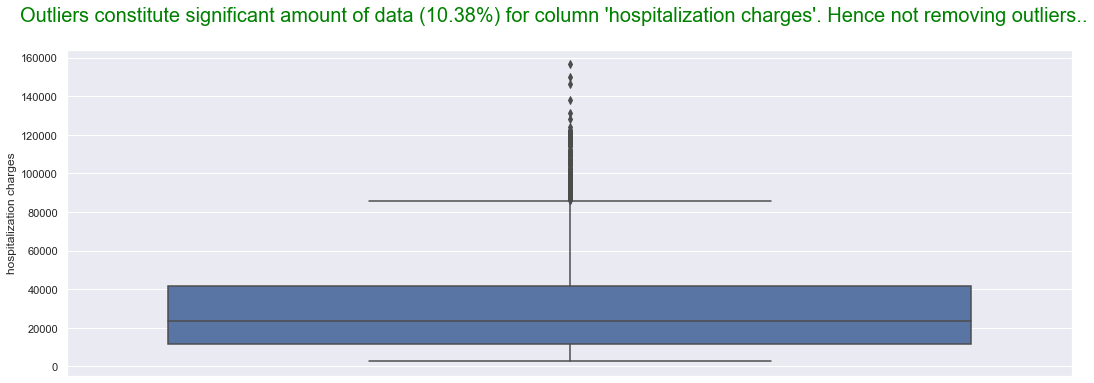

In [12]:
for column in get_columns_by_types(df, numeric_types):
    df = remove_outlier(df, column)

***
***
## **4. Univariate Analysis (Categorical Data).**

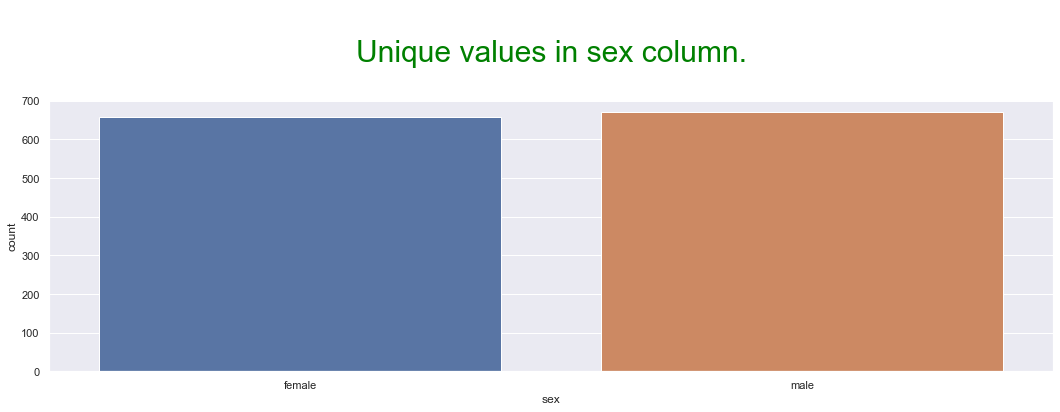

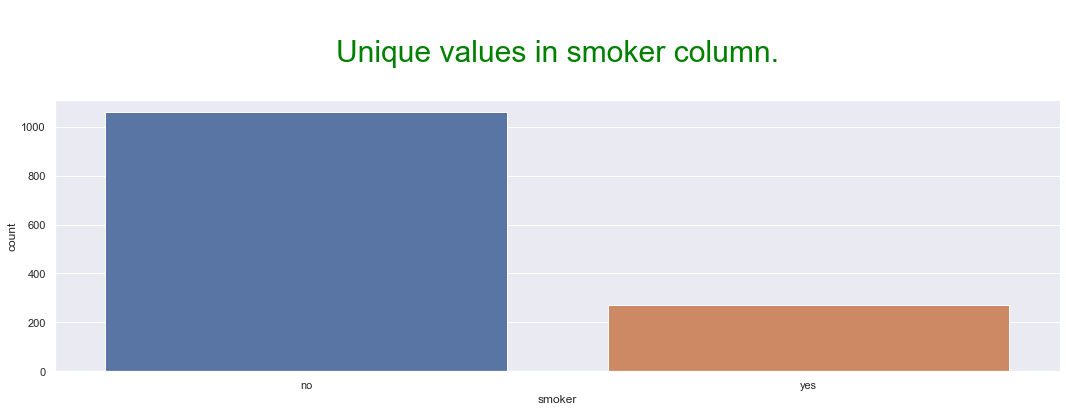

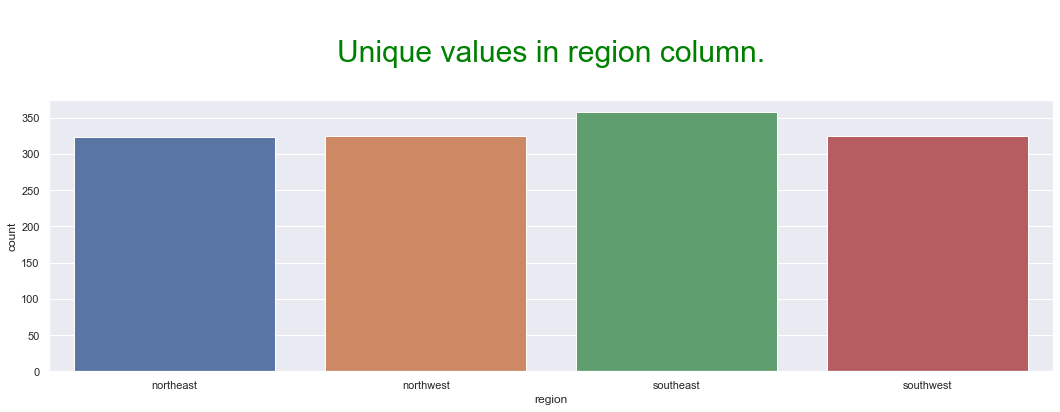

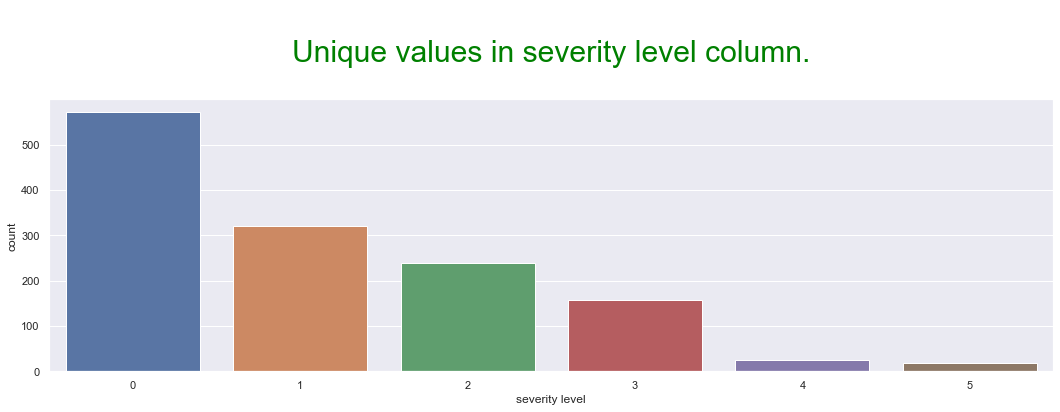

In [13]:
for column in get_columns_by_types(df, categorical_types):
    fig, axes = plt.subplots(figsize=(18,5))
    sns.countplot(data=df, x=column)
    plt.title(f"\nUnique values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **5. Univariate Analysis (Discrete Data).**

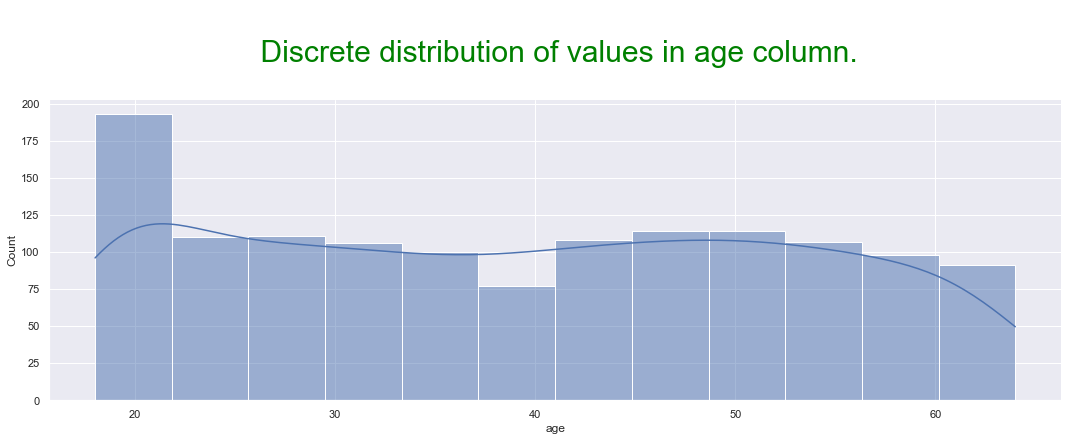

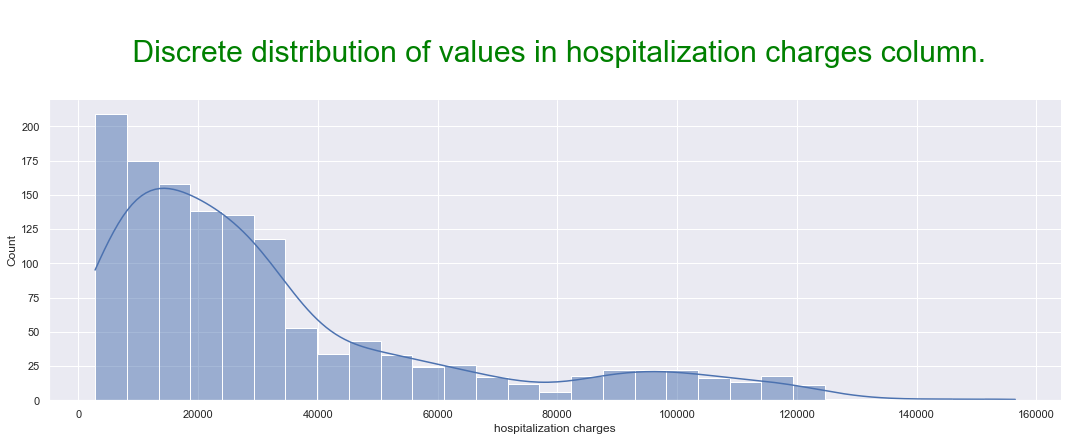

In [14]:
for column in get_columns_by_types(df, discrete_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Discrete distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **6. Univariate Analysis (Continuous Data).**

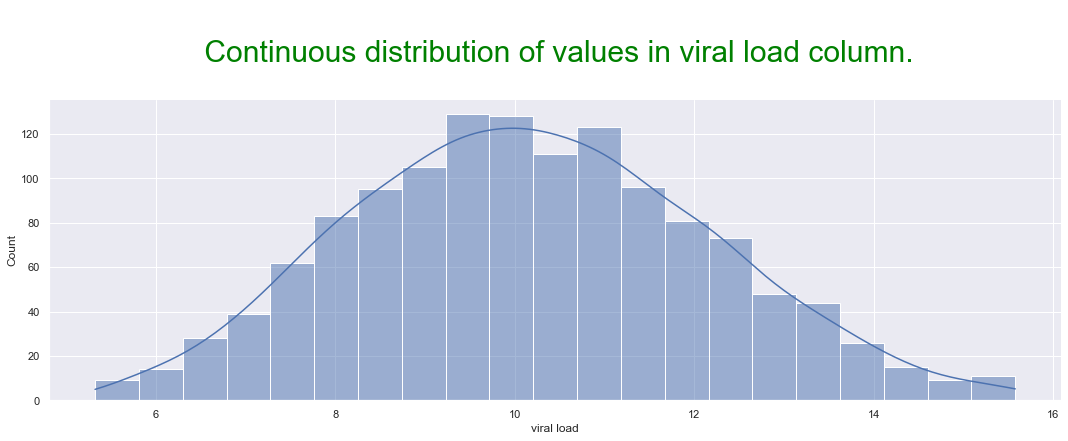

In [15]:
for column in get_columns_by_types(df, continuous_types):
    sns.displot(df[column], kde=True, height=5, aspect=3)
    plt.title(f"\n Continuous distribution of values in {column} column.\n", fontsize=30, color="green")
    plt.show()

***
***
## **7. Bivariate Analysis.**

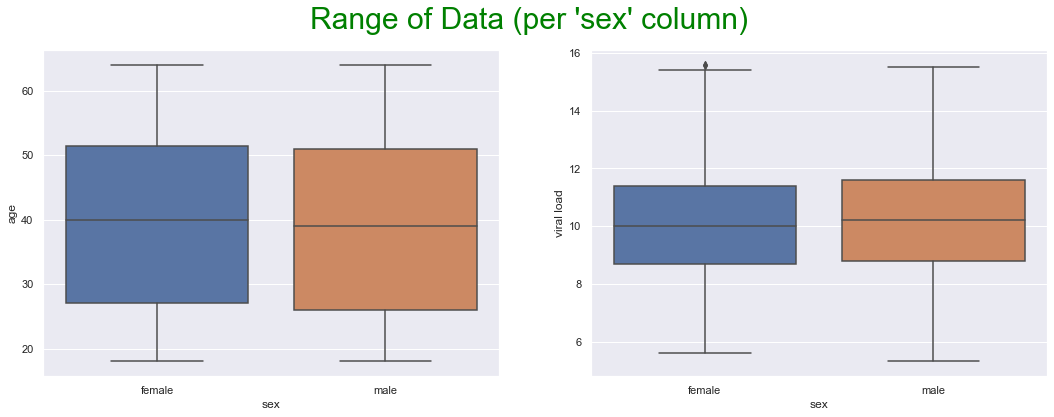

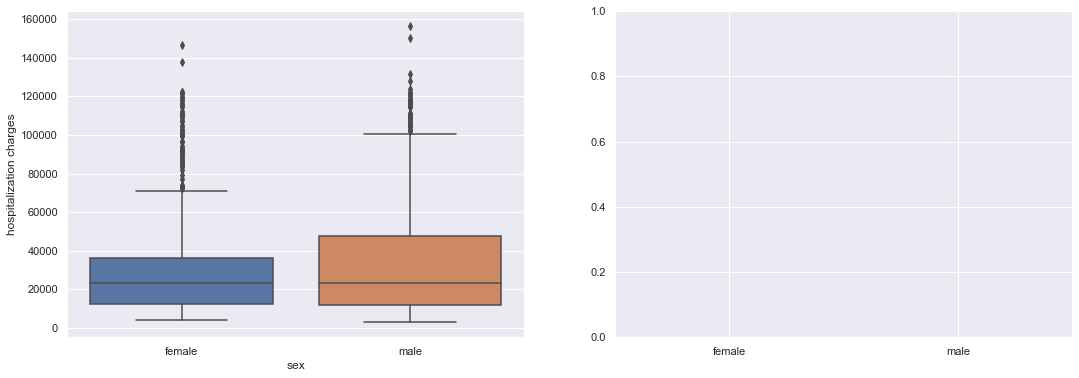

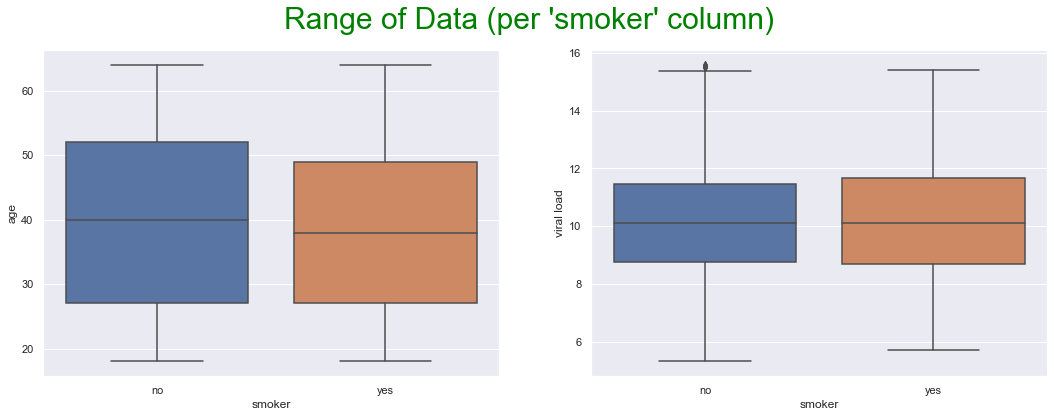

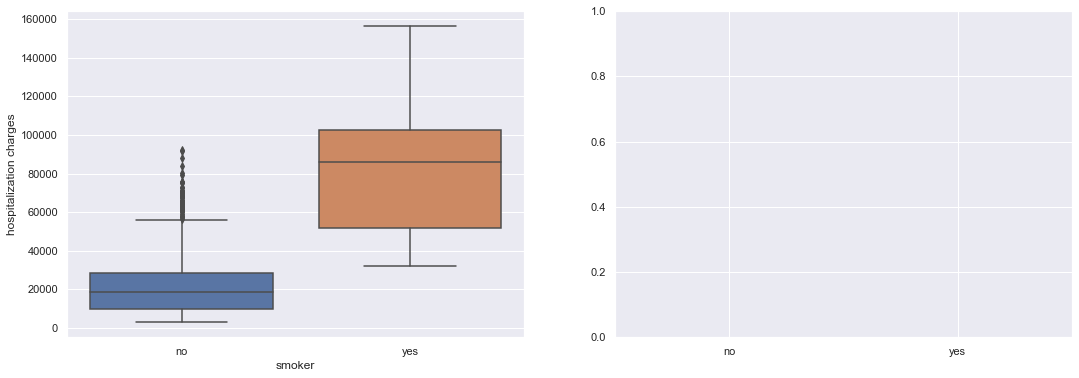

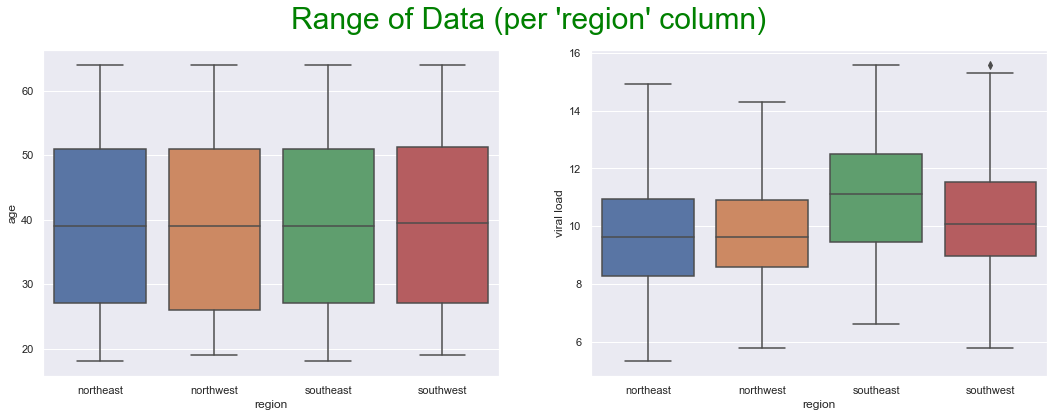

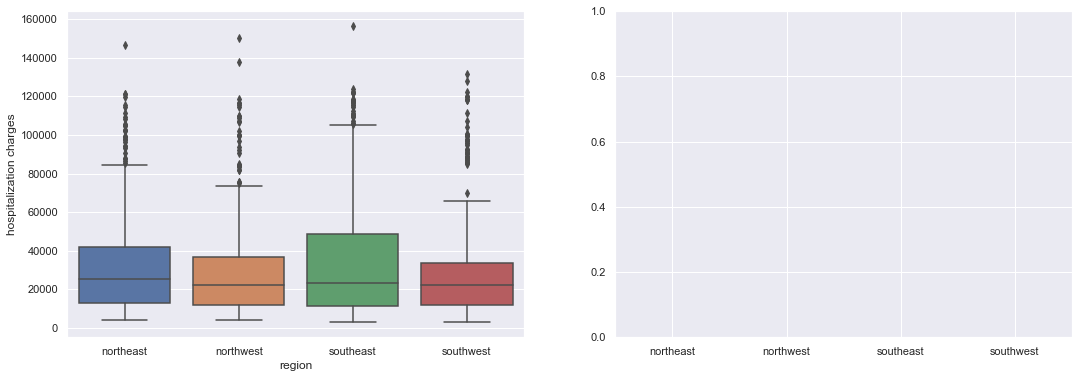

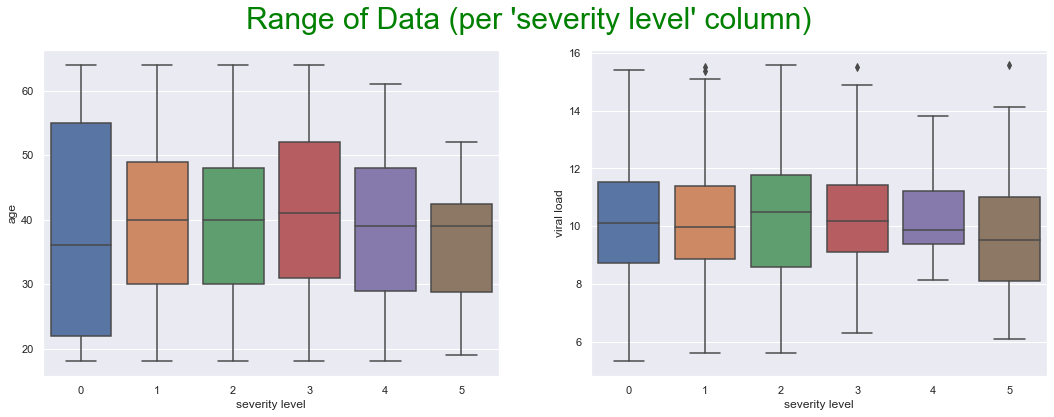

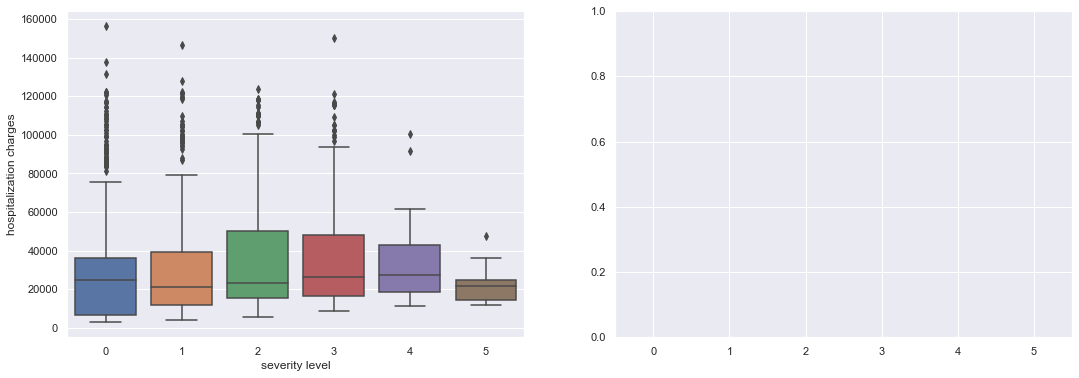

In [16]:
for category in get_columns_by_types(df, categorical_types):
    column_index = 0
    while column_index < len(get_columns_by_types(df, numeric_types)):
        fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
        if  column_index == 0:
            fig.suptitle(f"Range of Data (per '{category}' column)", fontsize=30, color="green")
        sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[0], x=category)
        column_index += 1
        if column_index < len(get_columns_by_types(df, numeric_types)):
            sns.boxplot(data=df, y=get_columns_by_types(df, numeric_types)[column_index], ax=axes[1], x=category)
            column_index += 1
        plt.show()

***
***
## **8. Analysis of Correlation Between Data.**

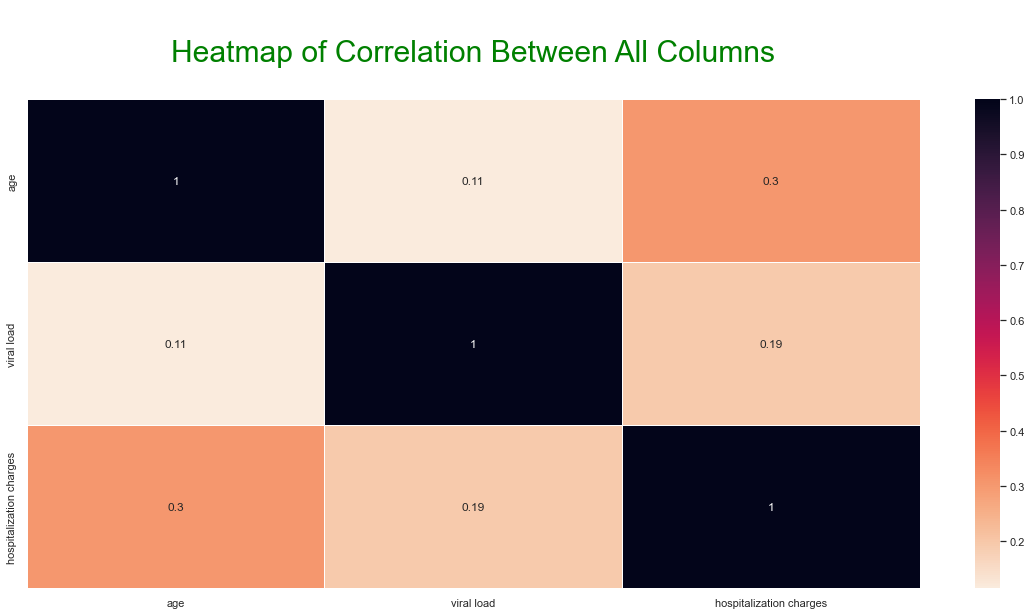

In [17]:
fig, ax = plt.subplots(figsize=(20,9))
sns.heatmap(df.corr(), linewidths=.5, cmap=sns.cm.rocket_r, annot=True, ax=ax)
plt.title("\nHeatmap of Correlation Between All Columns\n", fontsize=30, color="green")
plt.show()

***
***
## **9. Comparison of Hospitalization Charges for Smokers and Non-smokers using Hypothesis Testing.**

In [19]:
smoker = df[df['smoker']=='yes']['hospitalization charges']
nonsmoker = df[df['smoker']=='no']['hospitalization charges']

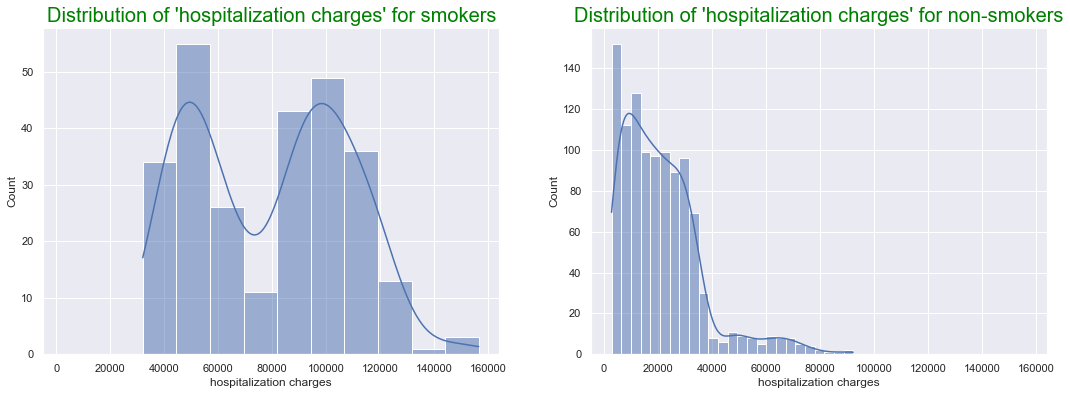

In [20]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(smoker, kde=True, ax=axes[0]).set_title("Distribution of 'hospitalization charges' for smokers", fontsize=20, color="green")
sns.histplot(nonsmoker, kde=True, ax=axes[1]).set_title("Distribution of 'hospitalization charges' for non-smokers", fontsize=20, color="green")
plt.show()

***
### Distributions are right skewed. Hence, trying different transformations to make them roughly Guassian.

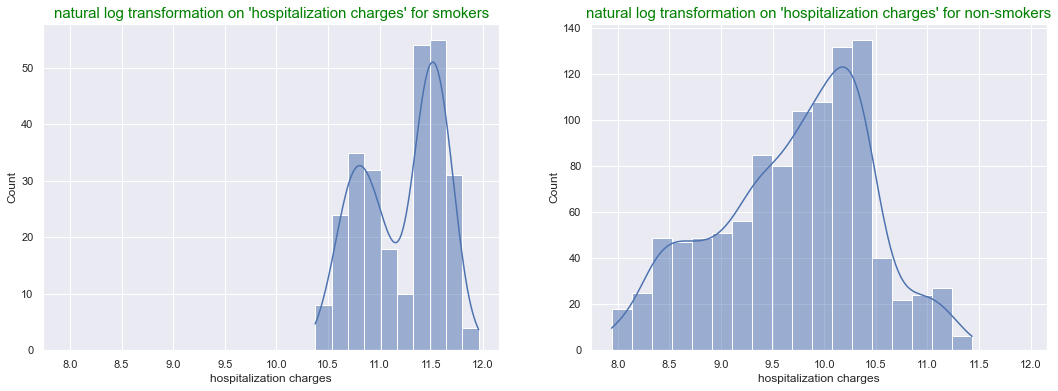

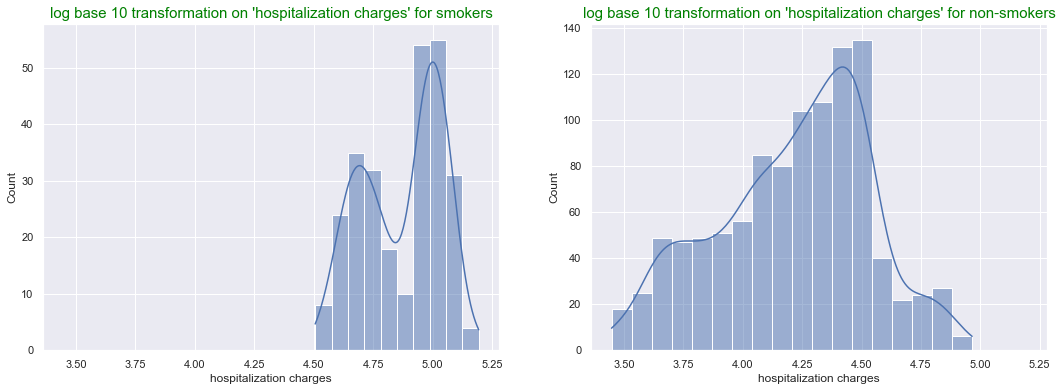

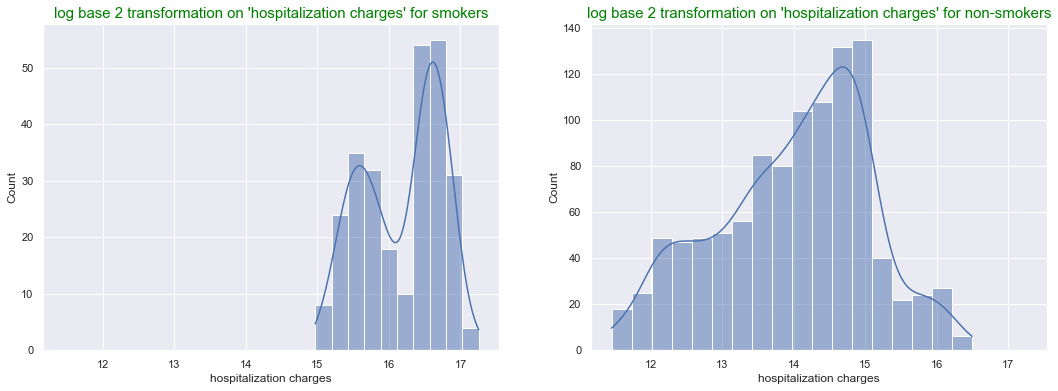

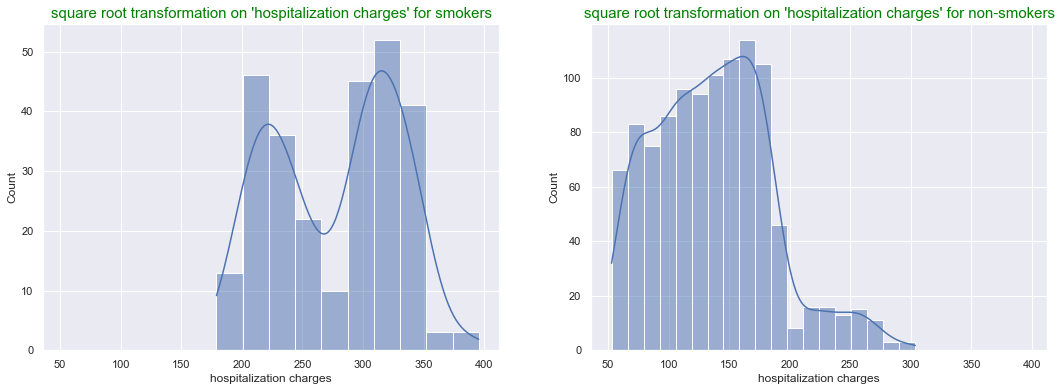

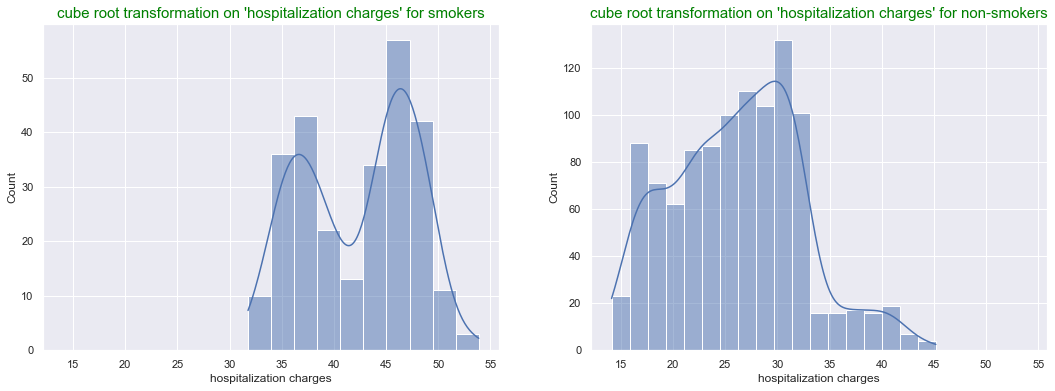

In [23]:
for transformation in right_skew_transformations:
    fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
    f1 = sns.histplot(smoker.apply(transformation[1]), kde=True, ax=axes[0])
    f1.set_title(f"{transformation[0]} transformation on 'hospitalization charges' for smokers", fontsize=15, color="green")
    f2 = sns.histplot(nonsmoker.apply(transformation[1]), kde=True, ax=axes[1])
    f2.set_title(f"{transformation[0]} transformation on 'hospitalization charges' for non-smokers", fontsize=15, color="green")
    plt.show()

***
### Even though, none of the transformations are making data visually look roughly Guassian, still proceeding further for t-test with the existing data since the sample size is significantly large.

In [25]:
np.std(smoker)**2, np.std(nonsmoker)**2

(807061029.8966523, 225001835.95113286)

***
### Even though, the variances are not equal, still proceeding further with the t-test since the sample size is significantly large.

***
### **Applying Unpaired T-Test**
***
### **H0** = The mean difference for 'hospitalization charges' between unpaired observations for 'smokers' and 'non-smokers' is zero.
### **H1** = The mean difference for 'hospitalization charges' between unpaired observations for 'smokers' is grater than 'non-smokers'.

### **Significance Level (α)** = 0.05

In [36]:
stats.ttest_ind(smoker.sample(100), nonsmoker.sample(100), equal_var=False,  alternative='greater')

Ttest_indResult(statistic=17.0131571235393, pvalue=7.247138950448632e-36)

In [37]:
stats.ks_2samp(smoker.sample(100), nonsmoker.sample(100))

KstestResult(statistic=0.91, pvalue=2.596277269141426e-44)

***
### Rejected null hypothesis as the p-value is less than the significance level.

***
***
## **10. Comparison of Viral Loads for Males and Females using Hypothesis Testing.**

In [38]:
male = df[df['sex']=='male']['viral load']
female = df[df['sex']=='female']['viral load']

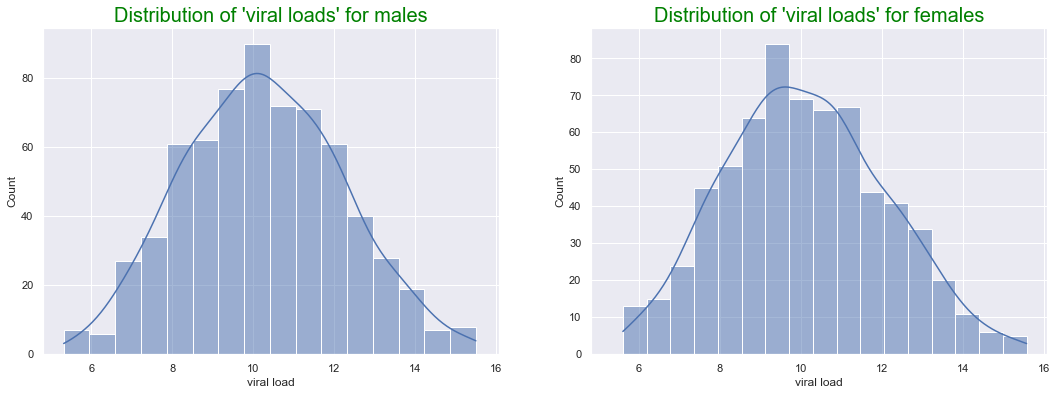

In [39]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,6))
sns.histplot(male, kde=True, ax=axes[0]).set_title("Distribution of 'viral loads' for males", fontsize=20, color="green")
sns.histplot(female, kde=True, ax=axes[1]).set_title("Distribution of 'viral loads' for females", fontsize=20, color="green")
plt.show()

***
### Distributions visually look roughly Guassian, so proceeding further with the t-test without any transformations.

In [44]:
np.std(male)**2, np.std(female)**2

(3.849162792604137, 3.9218507956829796)

***
### Variances are approximately equal, so proceeding further with the t-test.

***
### **Applying Unpaired T-Test**
***
### **H0** = The mean difference for 'viral loads' between unpaired observations for 'males' and 'females' is zero.
### **H1** = The mean difference for 'viral loads' between unpaired observations for 'males' and 'females' is not zero.

### **Significance Level (α/2)** = 0.025

In [47]:
stats.ttest_ind(male.sample(100), female.sample(100), equal_var=True,  alternative='two-sided')

Ttest_indResult(statistic=0.5192662078436855, pvalue=0.6041550596645315)

***
### Failed to reject null hypothesis as the p-value is higher than significance level.

***
***
## **11. Chi square test to analyze if the proportion of smoking is significantly different across different regions.**
### **H0: Proportion of smoking is not different across different regions.**
### **H1: Proportion of smoking is different across different regions.**

### **Significance Level (α)** = 0.05
***
***

In [54]:
contingency_table = pd.crosstab(df['smoker'],df['region'])
contingency_table

region,northeast,northwest,southeast,southwest
smoker,,,,
no,256,267,268,267
yes,67,58,89,57


***
### Testing assumptions of Chi-Square test.
#### 1. Categorical Variables = Yes
#### 2. Independent Observations = Yes
#### 3. Cells in the contingency table are mutually exclusive = Yes
#### 4. Values in cells should be greater than 5 = Yes

In [55]:
stat, p, dof, expected = stats.chi2_contingency(contingency_table)
stat, p

(7.41509003066203, 0.05978076201764091)

***
### Failed to reject null hypothesis as the p-value is higher than significance level.

***
***
## **12. Anova test to analyze if the mean viral load of women with different severity levels same.**
### **H0: mean viral load is same for women with different severity levels.**
### **H1: mean viral load is not same for women with different severity levels.**
### **Significance Level (α)** = 0.05
***
***

In [65]:
female = df[(df['sex']=='female')]
level_0 = female[female['severity level']==0]['viral load']
level_1 = female[female['severity level']==1]['viral load']
level_2 = female[female['severity level']==2]['viral load']

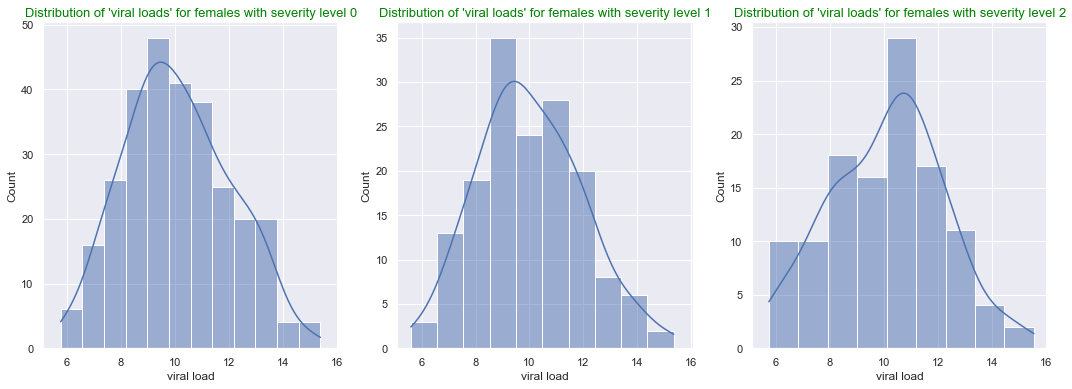

In [71]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(18,6))
sns.histplot(level_0, kde=True, ax=axes[0]).set_title("Distribution of 'viral loads' for females with severity level 0", fontsize=13, color="green")
sns.histplot(level_1, kde=True, ax=axes[1]).set_title("Distribution of 'viral loads' for females with severity level 1", fontsize=13, color="green")
sns.histplot(level_2, kde=True, ax=axes[2]).set_title("Distribution of 'viral loads' for females with severity level 2", fontsize=13, color="green")
plt.show()

***
### Distributions visually look roughly Guassian, so proceeding further with the Anova test without any transformations.

In [72]:
np.std(level_0)**2, np.std(level_1)**2, np.std(level_2)**2

(3.8440222499517747, 3.6977404262137497, 4.353871415004748)

***
### Even though, the variances are not equal, still proceeding further with the Anova test.

In [74]:
stats.f_oneway(level_0, level_1, level_2)

F_onewayResult(statistic=0.11717048239408508, pvalue=0.8894553469550055)

In [75]:
stats.kruskal(level_0, level_1, level_2)

KruskalResult(statistic=0.38729287428068637, pvalue=0.8239491706000333)

***
### Failed to reject null hypothesis as the p-value is higher than significance level.

***
***
## **13. Business Insights.**
#### **A.** Non-smokers are approximately 5 times more in number than Smokers.
#### **B.** The number of patients with Severity Level 1 are less than the number of patients with Severity Level 0.
#### **C.** The number of patients with Severity Level 2 are less than the number of patients with Severity Level 1.
#### **D.** The number of patients with Severity Level 3 are less than the number of patients with Severity Level 2.
#### **E.** The number of patients with Severity Level 4 and 5 are less than the number of patients with Severity Level 3.
#### **F.** Majority of the patients have the low Hospitalization Charges.
#### **G.** Smokers have significantly higher Hospitalization Charges than the Non-smokers.
#### **H.** There is no significan difference between Viral Loads for Males and Females.
#### **I.** Proportion of Smokers is significantly different across different regions.
#### **J.** mean viral load is same for women with different severity levels.
#### **K.** Patients with Severity Levels 4 and 5 are less than patients with Severity Levels 0, 1, 2 and 3. 

***
***
## **14. Recommendations.**
#### **A.** Smoker column should be used as a variable in predicting the Hospitalization Charges.
#### **B.** Gender column should not be used as a variable in predicting the Viral Loads.
#### **C.** Smoker column should be used as a variable in predicting the Hospitalizations across different regions.
#### **D.** Severity Level column should not be used as a variable in predicting the Viral Loads for Women.